In [28]:
# the PSNR of Modl method is 39.22 dB, ours are 45.08 dB
# see in https://github.com/hkaggarwal/modl

In [1]:
import os
import time
import cv2
import torch
import torch.nn as nn
import h5py
import numpy as np
import math

from src.models.condrefinenet import CondRefineNetDilated
from src.config import get_cfg_defaults
from src.data import numpy2tensor, image2tensor, tensor2image, tensor2complex, tensor_split
from src.metrics import psnr, ssim, batch_PSNR
from src.utils_TRPA import *
import matplotlib.pyplot as plt

from scipy.io import loadmat,savemat

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
label_num = 10
chp_path = './checkpoints/SIAT/net.pth'
states = torch.load(chp_path)
scorenet = CondRefineNetDilated(6,6,128).cuda()
scorenet.load_state_dict(states['weights'])
scorenet.eval();

In [3]:
filename='./data/modl/demoImage.hdf5' #set the correct path here
with h5py.File(filename,'r') as f:
    org,csm,mask=f['tstOrg'][:],f['tstCsm'][:],f['tstMask'][:]
#print(org.shape,csm.shape,mask.shape)
orim = org[0]
csm = csm[0]
patt = mask[0]

In [4]:
def FT(x,csm):
    """ This is a the A operator as defined in the paper"""
    ncoil,nrow,ncol = csm.shape
    ccImg=np.reshape(x,(nrow,ncol) )
    coilImages=np.tile(ccImg,[ncoil,1,1])*csm;
    kspace=np.fft.fft2(coilImages)/np.sqrt(nrow * ncol)
    return kspace

def tFT(kspaceUnder,csm):
    """ This is a the A^T operator as defined in the paper"""
    ncoil,nrow,ncol = csm.shape
    #temp=np.zeros((ncoil,nrow,ncol),dtype=np.complex64)
    img=np.fft.ifft2(kspaceUnder)*np.sqrt(nrow*ncol)
    coilComb=np.sum(img*np.conj(csm),axis=0).astype(np.complex64)
    #coilComb=coilComb.ravel();
    return coilComb

In [5]:
img_original = orim

img_original = img_original/np.max(np.abs(img_original))
mask_np = patt
#print(ori_complex.shape,csm.shape,mask.shape)
ksp = FT(img_original,csm)
print(ksp.shape)
if len(mask_np.shape)==2:
    mask_np=np.tile(mask_np,(csm.shape[0],1,1))
#get multi coil undersample kspace by mask

usksp = ksp * mask

image_zeroFilled = tFT(usksp,csm)

kspace_sampled = usksp

(12, 256, 232)


In [6]:
image_target = numpy2tensor(img_original).permute(2,0,1).unsqueeze(0).cuda() # only compute the PSNR

image_initial = numpy2tensor(image_zeroFilled).permute(2,0,1).unsqueeze(0).cuda()
# image_initial = torch.rand_like(image_target)

mask = torch.Tensor(mask_np).unsqueeze(0).unsqueeze(-1) #(1,h,w,1)
mask = torch.cat((mask,mask), dim=-1)

In [7]:
gamma=1.05
lam=1e-4
rho=0.003
max_iter=500
eps=1e-11
step_lr=0.43
verbose=True

v = image_initial.repeat(1,3,1,1)
x = v.clone()
u = torch.zeros_like(v)

psnrs = []
rho_k = rho
time1 = time.time()
for idx in range(max_iter):
    x_old = x.clone()
    v_old = v.clone()
    u_old = u.clone()
    #-----------------------------------------------
    # denoising step
    #-----------------------------------------------
    sigma = math.sqrt(lam/rho_k)
    sigma = torch.tensor(sigma).to(x.device)
    sigma = sigma.view(1,1,1,1)
    with torch.no_grad():
        inputs = x + u + torch.randn_like(x).clip(-0.8,0.8) * sigma
        logp = scorenet(inputs, sigma/math.sqrt(2))
        clip_c = sigma.sqrt().squeeze().item()
        v = x + u + step_lr*torch.clamp(logp*sigma**2,-clip_c,clip_c)

    #-----------------------------------------------
    # projection step
    #-----------------------------------------------
    v_sub_u = tensor_split(v - u)
    
    v_sub_u_complex = tensor2complex(v_sub_u)
    iterkspace = FT(v_sub_u_complex,csm)*(1-mask_np)
    iterkspace = kspace_sampled + iterkspace#*(1-mask)
    v_sub_u_complex  = tFT(iterkspace,csm)
    x = numpy2tensor(v_sub_u_complex).permute(2,0,1).unsqueeze(0).to(x.device)
    #-----------------------------------------------
    # multiplier update step
    #-----------------------------------------------
    u = x - v_sub_u
    
    u = u.repeat(1,3,1,1)
    x = x.repeat(1,3,1,1)

    if image_target is not None:
        PSNR = batch_PSNR(image_target, tensor_split(x))
        psnrs.append(PSNR)

    rho_k = gamma*rho_k

    if verbose and (idx%10 == 0):
        print(f'iter: {idx}, rho: {rho_k}, sigma: {int(sigma*255)}, PSNR: {PSNR}, TIME: {time.time()-time1}')

    delta = (v_old-v).pow(2).mean() + (u_old-u).pow(2).mean() + (x_old-x).pow(2).mean()
    if delta < eps:
        break

iter: 0, rho: 0.00315, sigma: 46, PSNR: 24.434223641675516, TIME: 0.8916623592376709
iter: 10, rho: 0.005131018074348942, sigma: 36, PSNR: 27.611623396595203, TIME: 3.211634635925293
iter: 20, rho: 0.008357887771204931, sigma: 28, PSNR: 28.978697065092373, TIME: 5.495657920837402
iter: 30, rho: 0.013614118481724603, sigma: 22, PSNR: 30.18697816835653, TIME: 7.784557342529297
iter: 40, rho: 0.022175964443192676, sigma: 17, PSNR: 31.359273251545893, TIME: 10.07432770729065
iter: 50, rho: 0.03612230932512416, sigma: 13, PSNR: 32.462536121297056, TIME: 12.353373289108276
iter: 60, rho: 0.05883943556648745, sigma: 10, PSNR: 33.47682838960059, TIME: 14.637275457382202
iter: 70, rho: 0.0958432404368689, sigma: 8, PSNR: 34.48354357140449, TIME: 16.913321256637573
iter: 80, rho: 0.15611853936055423, sigma: 6, PSNR: 35.49635225723559, TIME: 19.213340044021606
iter: 90, rho: 0.2543006499047494, sigma: 5, PSNR: 36.4303923879878, TIME: 21.50688123703003
iter: 100, rho: 0.41422896221585775, sigma: 4

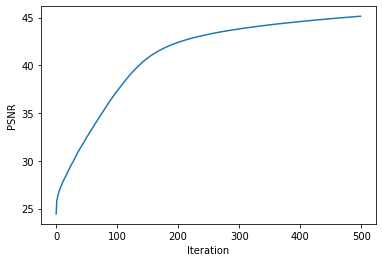

In [8]:
fig  = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(psnrs)
plt.ylabel("PSNR")
plt.xlabel("Iteration")
plt.show()